In [ ]:
import logging
from copy import copy
from enum import Enum

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

from IPython.display import clear_output
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, AngleAxis,
                         Concatenate, DiagramBuilder, InputPortIndex,
                         LeafSystem, MeshcatVisualizer, ContactVisualizerParams, ContactVisualizer, MeshcatVisualizerParams, Parser,
                         PiecewisePolynomial, PiecewisePose, PointCloud, RandomGenerator, RigidTransform,
                         RollPitchYaw, Simulator, StartMeshcat,
                         UniformlyRandomRotationMatrix,
                         BsplineTrajectory, Sphere, Rgba,
                         KinematicTrajectoryOptimization, Solve, MinimumDistanceConstraint,
                         PositionConstraint, ModelInstanceIndex,
                         SpatialVelocity, LinearConstraint, BoundingBoxConstraint, LogVectorOutput,
                         IpoptSolver,SnoptSolver)

from manipulation import FindResource, running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import (AddPackagePaths,
                                    MakeManipulationStation, AddIiwa, AddShape, AddWsg, AddMultibodyTriad)

import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox
from io import StringIO
import sys

from utils import *

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://68a898be-bd4e-4046-916a-6293aadf6c5d.deepnoteproject.com/7000/


The order of operations:
1. We start with comfortable joint angles for the iiwa q_throw and q_catch.
1. We use forward kinematics to get spatial positions p_WThrow and p_WCatch
1. we translate those by the offset between the ball and the gripper p_GB_G, to get the spatial positions the ball will be in at the point of being thrown (release) and caught X_WThrowB_W, X_WCatchB_W
1. we calculate using simple physics the spatial velocity of the ball at the point of being thrown and caught V_WThrowB_W, V_WCatchB_W, as well as the joint angle for the last iiwa link (rotation of the gripper such that it will parallel to the velocity of the ball), given a particular max height h that it reaches.
1. we use the Jacobian to transform the spatial velocities of the ball into joint velocities of the iiwa v_Throw and v_Catch, using the known offset between the gripper and the ball to create the Jacobian
1. We feed the joint positions and velocities into kin traj opt so they can be used as constraints to optimize the trajectory.


In [ ]:
internal_model = make_internal_model()
# Manipulation Station Parameters
time_step=0.0001
# use_direct determines whether to feed the desired q, v, a into InverseDynamicsController
# or to use the default position based iiwa controller
use_direct = True

display_plot = True
add_text_to_pdf = False
should_print_contact_results = False

t_settle = 0.0
squash_ball_radius = 0.02
p_GB_G = [0, 0.11, 0]
def add_target_objects(X_WThrow, X_WCatch):
    p_ThrowB_W = X_WThrow.rotation() @ p_GB_G
    X_WThrowB_W = RigidTransform(X_WThrow.rotation(), X_WThrow.translation() +  p_ThrowB_W)
    p_CatchB_W = X_WCatch.rotation() @ p_GB_G
    X_WCatchB_W = RigidTransform(X_WCatch.rotation(), X_WCatch.translation() +  p_CatchB_W)
    meshcat.SetObject("throw", Sphere(squash_ball_radius), rgba=Rgba(.9, .1, .1, 1))
    meshcat.SetTransform("throw", X_WThrowB_W)
    meshcat.SetObject("catch", Sphere(squash_ball_radius), rgba=Rgba(.1, .9, .1, 1))
    meshcat.SetTransform("catch", X_WCatchB_W)
    return X_WThrowB_W, X_WCatchB_W

q_Throw = np.array([-0.54, 0.58, 0, -1.79, 0, -0.79, 0])
p_WThrow = [0.57, -0.34, 0.39]
R_WThrow = RollPitchYaw([-np.pi, 0.00, 1.03])

q_Catch = np.array([-0.74, 0.58, 0, -1.79, 0, -0.79, 0])
p_WCatch = [0.49, -0.45, 0.39]
R_WCatch = RollPitchYaw([-np.pi, 0.00, 0.83])

X_WThrow = RigidTransform(R_WThrow, p_WThrow)
X_WCatch = RigidTransform(R_WCatch, p_WCatch)

X_WThrowB_W, X_WCatchB_W = add_target_objects(X_WThrow, X_WCatch)

max_height = 0.5 # Max height ball will reach in meters
V_ThrowB, V_CatchB, t_duration = calculate_ball_vels(X_WThrowB_W.translation(), X_WCatchB_W.translation(), max_height)
original_t_duration = round(t_duration,3)
time_scale_factor = 1 #0.936
t_duration = t_duration * time_scale_factor
t_duration = round(t_duration,3)
# print(f"original t_duration: {original_t_duration}")
# print(f"scaled t_duration: {t_duration}")

sim_duration = 7.5 * t_duration

velocity_scale_factor = 1 # 1.32
original_V_ThrowB = V_ThrowB
original_V_CatchB = V_CatchB
def scale_vector(vec, scale_factor):
    return vec * scale_factor
V_ThrowB = scale_vector(V_ThrowB, velocity_scale_factor)
V_CatchB = scale_vector(V_CatchB, velocity_scale_factor)

# print(f"velocity_scale_factor: {velocity_scale_factor}")
# print(f"original V_ThrowB: {original_V_ThrowB}, scaled V_ThrowB: {V_ThrowB}")
# print(f"original V_CatchB: {original_V_CatchB}, scaled V_CatchB: {V_CatchB}")

v_Throw = convert_spatial_vel_ball_to_joint_vel_arm(q_Throw, V_ThrowB, p_GB_G)
v_Catch = convert_spatial_vel_ball_to_joint_vel_arm(q_Throw, V_CatchB, p_GB_G)

# WSG gripper
wsg_buff_open = 0.001  #0.015
wsg_buff_close = 0.1
should_release_ball = True
if should_release_ball:
    opened = np.array([0.090]) # [0.050] #[0.035]
else:
    opened = np.array([0.02]) #[0.035]
closed = np.array([0.02])

# Kin Traj Opt Parameters
num_control_points = 21
use_spatial_constraints = True

print(X_WCatchB_W)

RigidTransform(
  R=RotationMatrix([
    [0.6748757600712672, 0.7379313711099627, -9.037052916202334e-17],
    [0.7379313711099627, -0.6748757600712672, 8.264844393934144e-17],
    [-0.0, -1.2246467991473532e-16, -1.0],
  ]),
  p=[0.5711724508220959, -0.5242363336078394, 0.39],
)


In [ ]:
# joints
def make_kin_traj_opt_trajectory(q_Throw, q_Catch, v_Throw, v_Catch, t_duration):
    return

In [ ]:
from pydrake.all import (SpatialVelocityConstraint)
# num_control_points = 11
def make_kin_traj_opt_trajectory_spatial_constraints(q_Throw, q_Catch, V_ThrowB, V_CatchB, t_duration):
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa, welded=True, sphere=True)
    gripper_frame = plant.GetFrameByName("body", wsg)
    plant.Finalize()

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)

    diagram_autodiff = diagram.ToAutoDiffXd()
    context_autodiff = diagram_autodiff.CreateDefaultContext()
    plant_autodiff = diagram_autodiff.GetSubsystemByName("plant")
    plant_context_autodiff = plant_autodiff.GetMyContextFromRoot(context_autodiff)
    gripper_frame_autodiff = plant_autodiff.GetFrameByName("body", wsg)

    # Initialize KinTrajOpt
    num_positions = 7
    num_control_points = 11
    trajopt = KinematicTrajectoryOptimization(num_positions, num_control_points)
    prog = trajopt.get_mutable_prog()

    q_guess = np.tile(q_Catch.reshape((num_positions,1)), (1, trajopt.num_control_points()))
    q_guess[0,:] = np.linspace(q_Catch[0], q_Throw[0], trajopt.num_control_points())
    path_guess = BsplineTrajectory(trajopt.basis(), q_guess)
    trajopt.SetInitialGuess(path_guess)

    trajopt.AddPathLengthCost(1)

    trajopt.AddPositionBounds(plant.GetPositionLowerLimits()[:num_positions],
                                plant.GetPositionUpperLimits()[:num_positions])
    trajopt.AddVelocityBounds(plant.GetVelocityLowerLimits()[:num_positions],
                                plant.GetVelocityUpperLimits()[:num_positions])

    # Add Position and Velocity Bounds based on iiwa
    #trajopt.AddPositionBounds(
    #    [-2.96706, -2.0944, -2.96706, -2.0944, -2.96706, -2.0944, -3.05433],
    #    [2.96706, 2.0944, 2.96706, 2.0944, 2.96706, 2.0944, 3.05433])
    # trajopt.AddVelocityBounds([-10] * 7, [10] * 7)

    # Constrain duration to be exact duration
    trajopt.AddDurationConstraint(2 * t_duration, 2 * t_duration)

    # Constrain positions in joint angles
    trajopt.AddPathPositionConstraint(q_Catch, q_Catch, 0)
    trajopt.AddPathPositionConstraint(q_Throw, q_Throw, 0.5)
    trajopt.AddPathPositionConstraint(q_Catch, q_Catch, 1)

    prog.AddQuadraticErrorCost(np.eye(7), q_Catch,
                                trajopt.control_points()[:, 0])

    prog.AddQuadraticErrorCost(np.eye(7), q_Throw,
                                trajopt.control_points()[:, np.round(num_control_points/2).astype(int)])

    prog.AddQuadraticErrorCost(np.eye(7), q_Catch,
                                trajopt.control_points()[:, -1])

    eps = 1
    def offset_vec_by_eps(vec, eps):
        return vec - eps * np.linalg.norm(vec), vec + eps * np.linalg.norm(vec)

    # constrain positions in cartesian coordinates
    lb_p_WBCatch, ub_p_WBCatch = offset_vec_by_eps(X_WCatchB_W.translation(), eps)
    pos_constraint_catch = PositionConstraint(plant_autodiff, plant_autodiff.world_frame(),
                                            lb_p_WBCatch,
                                            ub_p_WBCatch, gripper_frame_autodiff,
                                            p_GB_G, plant_context_autodiff)
    # trajopt.AddPathPositionConstraint(pos_constraint_catch, 1)

    q_q_dot_Throw = np.concatenate((q_Throw.reshape(num_positions,1), v_Throw), axis = 0)
    q_q_dot_Catch = np.concatenate((q_Catch.reshape(num_positions,1), v_Catch), axis = 0)
    q_q_dot_Throw.reshape(2 * num_positions,1)
    q_q_dot_Catch.reshape(2 * num_positions,1)

    eps = 0.0001
    lb_Catch, ub_Catch = offset_vec_by_eps(q_q_dot_Catch, eps)
    lb_Throw, ub_Throw = offset_vec_by_eps(q_q_dot_Throw, eps)

    q_dot_bbox_constraint_Catch = BoundingBoxConstraint(lb_Catch, ub_Catch)
    q_dot_bbox_constraint_Throw = BoundingBoxConstraint(lb_Throw, ub_Throw)

    q_dot_bbox_constraint_Catch = BoundingBoxConstraint(lb_Catch, ub_Catch)
    q_dot_bbox_constraint_Throw = BoundingBoxConstraint(lb_Throw, ub_Throw)

    trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint_Catch, 0)
    trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint_Throw, 0.5)
    # trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint_Catch, 1)

    lb_Catch, ub_Catch = offset_vec_by_eps(V_CatchB, eps)
    vel_constraint_catch = SpatialVelocityConstraint(
                                plant = plant_autodiff,
                                frameA = plant_autodiff.world_frame(),
                                v_AC_lower = lb_Catch,
                                v_AC_upper = ub_Catch,
                                frameB = gripper_frame_autodiff,
                                p_BCo = np.array(p_GB_G, dtype=np.float64).reshape(3,1),
                                plant_context = plant_context_autodiff
                        )
    trajopt.AddVelocityConstraintAtNormalizedTime(vel_constraint_catch, s=1)
    solver = SnoptSolver()
    result = solver.Solve(prog)
    if not result.is_success():
        print("Trajectory optimization failed, even without collisions!")
        print(result.get_solver_id().name())
    
    pos_traj = trajopt.ReconstructTrajectory(result)
    vel_traj = pos_traj.MakeDerivative()
    acc_traj = vel_traj.MakeDerivative()

    return pos_traj, vel_traj, acc_traj
    return pos_traj, vel_traj, acc_traj

In [ ]:
class PlannerState(Enum):
    WAIT_FOR_OBJECTS_TO_SETTLE = 1
    PERPETUAL_MOTION = 2
    THINKING = 3

class Planner(LeafSystem):
    def __init__(self, plant):
        LeafSystem.__init__(self)
        self.DeclareAbstractInputPort(
            "body_poses", AbstractValue.Make([RigidTransform()]))
        self._throw_pose_index = self.DeclareAbstractInputPort(
            "throw_pose", AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()
        self._catch_pose_index = self.DeclareAbstractInputPort(
            "catch_pose", AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()
        self._wsg_state_index = self.DeclareVectorInputPort("wsg_state",
                                                            2).get_index()

        self._mode_index = self.DeclareAbstractState(
            AbstractValue.Make(PlannerState.PERPETUAL_MOTION))
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial()))
        self._times_index = self.DeclareAbstractState(AbstractValue.Make(
            {"initial": 0.0}))
        
        self._traj_start_time_index = self.DeclareAbstractState(
            AbstractValue.Make(0.0)
        )

        self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)
        self.DeclareVectorOutputPort("traj_start_time", 1, self.GetTrajStartTime)
        # For Perpetual Motion mode.
        num_positions = 7
        self._iiwa_position_index = self.DeclareVectorInputPort(
            "iiwa_position", num_positions).get_index()
                
        self.DeclareVectorOutputPort("iiwa_state_desired", 2 * num_positions,
                                     self.CalcIiwaDesiredState)
        self.DeclareVectorOutputPort("iiwa_acceleration_desired", num_positions,
                                     self.CalcIiwaDesiredAcceleration)
        self.DeclareVectorOutputPort("iiwa_position_command", num_positions,
                                     self.CalcIiwaPosition)

        self._traj_arm_q_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )
        self._traj_arm_v_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )
        self._traj_arm_a_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )

        self.DeclareInitializationUnrestrictedUpdateEvent(self.Initialize)

        self.DeclarePeriodicUnrestrictedUpdateEvent(0.1, 0.0, self.Update)

    def Update(self, context, state):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        current_time = context.get_time()
        times = context.get_abstract_state(int(
            self._times_index)).get_value()

        if mode == PlannerState.WAIT_FOR_OBJECTS_TO_SETTLE:
            if context.get_time() - times["initial"] > t_settle:
                self.GoCatchThrow(context, state)
            return
        if mode == PlannerState.PERPETUAL_MOTION:
            traj_q = context.get_mutable_abstract_state(int(
                self._traj_arm_q_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()
            if traj_start_time + traj_q.end_time() <= current_time:
                state.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).set_value(current_time)
                # print("restarting loop")
                # self.GoCatchThrow(context, state)
            return
        return

    def GoCatchThrow(self, context, state):        
        current_time = context.get_time()
        if use_spatial_constraints:
            q_traj, v_traj, a_traj= make_kin_traj_opt_trajectory_spatial_constraints(q_Throw, q_Catch, V_ThrowB, V_CatchB, t_duration)
        else:
            q_traj, v_traj, a_traj= make_kin_traj_opt_trajectory(q_Throw, q_Catch, v_Throw, v_Catch, t_duration)
        # Store them in states
        state.get_mutable_abstract_state(int(
            self._traj_start_time_index)).set_value(current_time)
        state.get_mutable_abstract_state(int(
            self._traj_arm_q_index)).set_value(q_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_v_index)).set_value(v_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_a_index)).set_value(a_traj)
        
        state.get_mutable_abstract_state(int(
            self._mode_index)).set_value(
                PlannerState.PERPETUAL_MOTION)

        # WSG Gripper Trajectory
        throw_time = original_t_duration
        catch_time = original_t_duration*2
        
        # Throw - Catch - Throw
        # times = [0, catch_time-buff, catch_time, throw_time-buff, throw_time]
        # positions = np.hstack([[opened], [opened], [closed], [closed], [opened]])
        # Catch - Throw - Catch Original
        times = [0, throw_time-wsg_buff_open, throw_time, catch_time-wsg_buff_close, catch_time]
        # positions = np.hstack([[closed], [closed], [opened], [opened], [closed]])
        # Catch - Throw - Catch tuned
        # times = [0, throw_time, throw_time+buff, catch_time-buff, catch_time]
        positions = np.hstack([[closed], [closed], [opened], [opened], [closed]])
        traj_wsg_command = PiecewisePolynomial.FirstOrderHold(times, positions)

        state.get_mutable_abstract_state(int(
            self._traj_wsg_index)).set_value(traj_wsg_command)

    def Plan(self, context, state):
        mode = copy(
            state.get_mutable_abstract_state(int(self._mode_index)).get_value())

    def CalcWsgPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()

        if mode == PlannerState.PERPETUAL_MOTION:
            traj_wsg = context.get_abstract_state(int(
                self._traj_wsg_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).get_value()
            # Evaluate the trajectory at the current time, and write it to the
            # output port.
            output.SetFromVector(traj_wsg.value(context.get_time()-traj_start_time))

            traj_start_time = context.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).get_value()

        else:
            # Command the open position
            output.SetFromVector([closed])
            return

    def CalcIiwaPosition(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        
        if mode == PlannerState.PERPETUAL_MOTION:
            traj_q = context.get_mutable_abstract_state(int(
                    self._traj_arm_q_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).get_value()
            output.SetFromVector(
                traj_q.value(
                    context.get_time()-traj_start_time))
        else:
            output.SetFromVector(q_Catch)

    def GetTrajStartTime(self, context, output):
        traj_start_time = context.get_abstract_state(int(self._traj_start_time_index)).get_value()
        output.SetFromVector([traj_start_time])

    def Initialize(self, context, state):
        self.GoCatchThrow(context, state)
        pass

    def CalcIiwaDesiredState(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        
        if mode == PlannerState.PERPETUAL_MOTION:
            traj_q = context.get_mutable_abstract_state(int(
                    self._traj_arm_q_index)).get_value()
            traj_v = context.get_mutable_abstract_state(int(
                    self._traj_arm_v_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).get_value()

            # CONCATENATE HERE TO MAKE STATE
            # print(context.get_time()-traj_start_time)
            traj_v_value = traj_v.value(context.get_time()-traj_start_time)
            traj_q_value = traj_q.value(context.get_time()-traj_start_time)
            traj_state_value = np.concatenate((traj_q_value, traj_v_value), axis=0)
            output.SetFromVector(traj_state_value)

        else:
            output.SetFromVector(q_Catch)
    
    def CalcIiwaDesiredAcceleration(self, context, output):
        mode = context.get_abstract_state(int(self._mode_index)).get_value()
        
        if mode == PlannerState.PERPETUAL_MOTION:
            # traj_q = context.get_mutable_abstract_state(int(
            #         self._traj_arm_q_index)).get_value()
            traj_a = context.get_mutable_abstract_state(int(
                    self._traj_arm_a_index)).get_value()
            traj_start_time = context.get_mutable_abstract_state(int(
                    self._traj_start_time_index)).get_value()

            traj_a_value = traj_a.value(context.get_time()-traj_start_time)
            output.SetFromVector(traj_a_value)            
            # output.SetFromVector(
            #     traj_q.value(
            #         context.get_time()-traj_start_time))
        else:
            output.SetFromVector(q_Catch)



In [ ]:
def vectors_within_eps(vec_a, vec_b, eps=0.005):
    return (vec_a <= vec_b + eps * np.linalg.norm(vec_b)).all() and (vec_a >= vec_b - eps * np.linalg.norm(vec_b)).all()

class BallValidator(LeafSystem):
    def __init__(self, name, body_index):
        LeafSystem.__init__(self)
        self._body_index = body_index
        self._traj_start_time_index = self.DeclareVectorInputPort("traj_start_time",1).get_index()
        self._body_poses_index = self.DeclareAbstractInputPort("body_poses",
                                    AbstractValue.Make([RigidTransform()])).get_index()
        self._body_spatial_velocities_index = self.DeclareAbstractInputPort("body_spatial_velocities",
                                    AbstractValue.Make([SpatialVelocity()])).get_index()
        self.DeclareForcedPublishEvent(self.Publish)

        self.DeclarePeriodicUnrestrictedUpdateEvent(0.001, 0.0, self.Update)

        self.find_pos_match = False
    
    def Update(self, context, state):
        traj_start_time = self.get_input_port(self._traj_start_time_index).Eval(context)
        pose = self.get_input_port(self._body_poses_index).Eval(context)[self._body_index]
        velocity = self.get_input_port(self._body_spatial_velocities_index).Eval(context)[self._body_index]

        if (context.get_time() == traj_start_time + original_t_duration): # traj_start_time + original_t_duration
            print(f"\nWe are at throw time! ({context.get_time()})")
            print(f"actual ball position = {pose.translation()}")
            print(f"actual ball velocity: {velocity.translational()}")
            meshcat.SetObject("actual_throw", Sphere(squash_ball_radius), rgba=Rgba(.1, .1, .9, 1))
            meshcat.SetTransform("actual_throw", pose)
            self.find_pos_match = True

        if (context.get_time() == 2 * original_t_duration): # traj_start_time + 2 * original_t_duration
            print(f"\nWe are at catch time! ({context.get_time()})")
            print(f"actual ball position = {pose.translation()}")
            print(f"actual ball velocity: {velocity.translational()}")
            meshcat.SetObject("actual_catch", Sphere(squash_ball_radius), rgba=Rgba(.9, .1, .9, 1))
            meshcat.SetTransform("actual_catch", pose)
            self.find_pos_match = True

        if self.find_pos_match and vectors_within_eps(pose.translation(), X_WCatchB_W.translation()):
            print(f"\nBall pose matches catch pose at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            self.find_pos_match = False

        if self.find_pos_match and vectors_within_eps(pose.translation(), X_WThrowB_W.translation()):
            print(f"\nBall pose matches throw pose at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            self.find_pos_match = False

        vel_eps = 0.001
        if vectors_within_eps(velocity.translational(), V_CatchB, vel_eps):
            print(f"\nBall velocity matches catch velocity at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            print(f"actual ball position = {pose.translation()}")
        
        if vectors_within_eps(velocity.translational(), V_ThrowB, vel_eps):
            print(f"\nBall velocity matches throw velocity at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            print(f"actual ball position = {pose.translation()}")


--- Experiment Parameters ---
Controller: Feed in desired q,v,a : True
simulation duration: 4.7925
manipulation station time step: 0.0001
kin traj opt use spatial vel constraints: True, num control points: 21
max height: 0.5
-----------------------------
planned ball THROW time: 0.639
planned ball THROW position: [0.664 -0.397 0.390]
planned ball THROW velocity: [-0.146 -0.200 3.132]
planned ball CATCH time: 1.278
planned ball CATCH position: [0.571 -0.524 0.390]
planned ball CATCH velocity: [-0.146 -0.200 -3.132]

We are at throw time! (0.639)
actual ball position = [0.666 -0.399 0.388]
actual ball velocity: [-0.145 -0.199 3.112]

Ball pose matches throw pose at (0.639)
actual ball velocity: [-0.145 -0.199 3.112]

We are at catch time! (1.278)
actual ball position = [0.580 -0.529 0.375]
actual ball velocity: [0.332 -0.657 -3.027]

We are at throw time! (1.939)
actual ball position = [0.913 -1.052 -0.430]
actual ball velocity: [0.505 -0.792 -0.000]

We are at throw time! (3.239)
actual

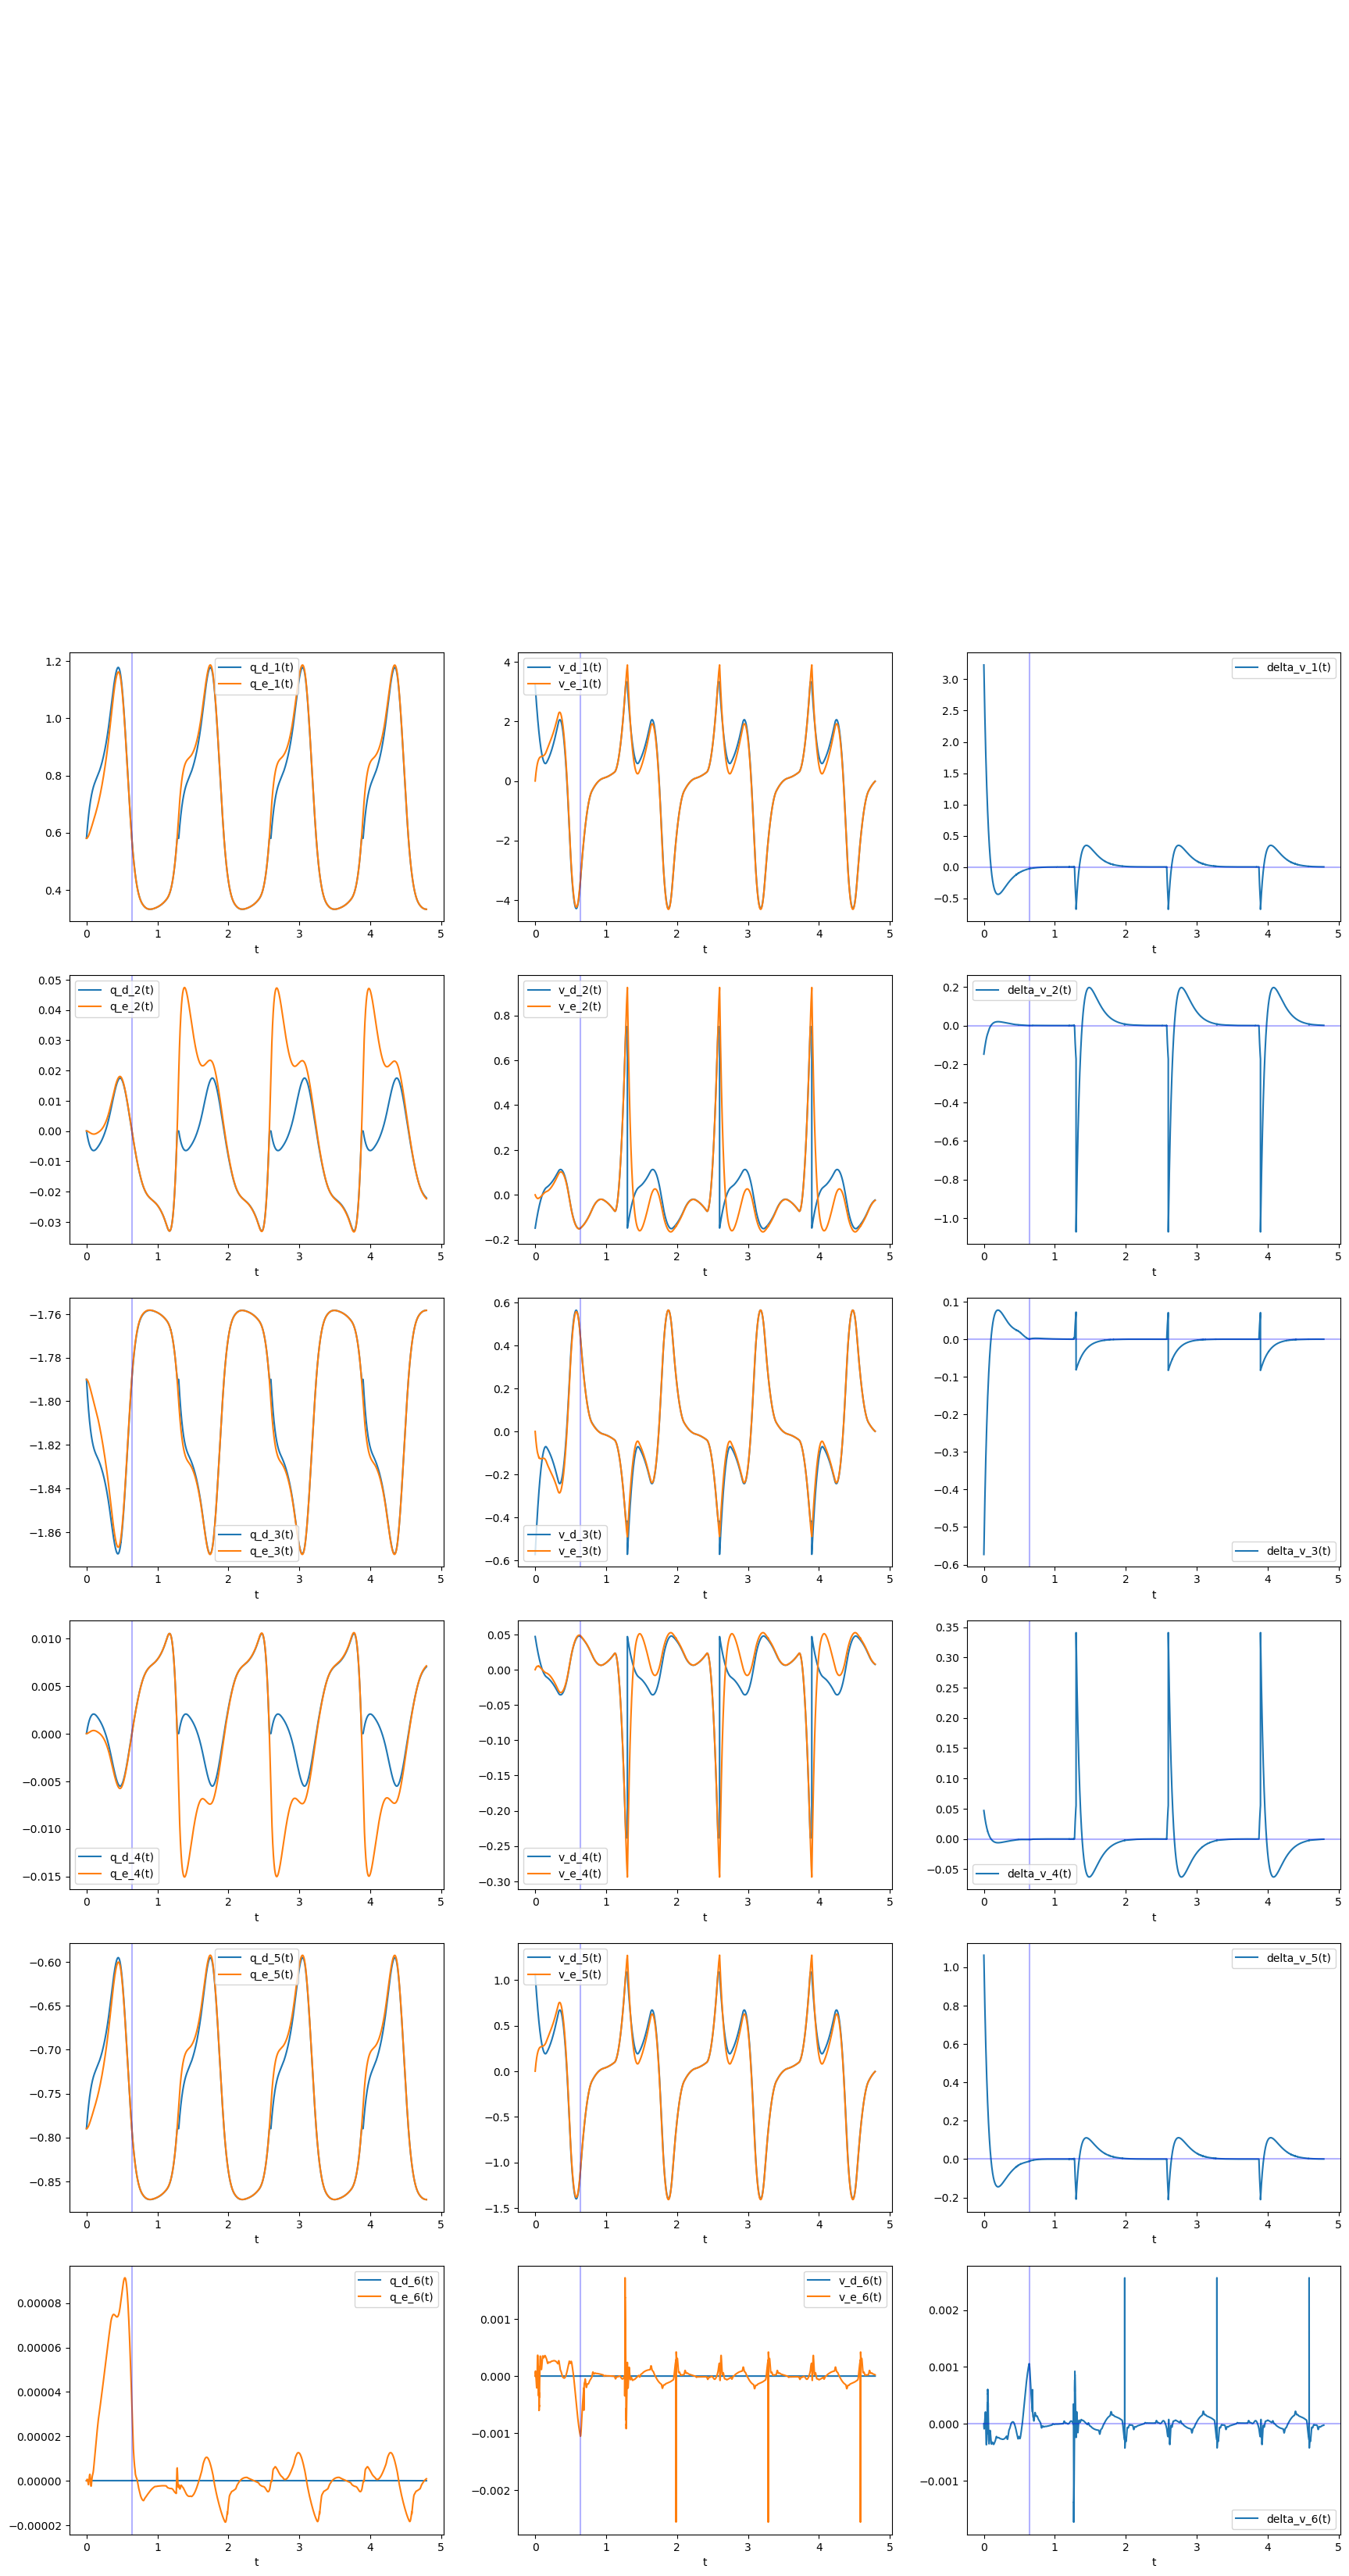

In [ ]:
def clutter_clearing_demo():
    meshcat.Delete()
    builder = DiagramBuilder()

    model_directives = """
directives:
"""

    for i in range(1 if running_as_notebook else 2):
        model_directives += f"""
- add_model:
    name: ball{i}
    file: package://one_arm_juggling/models/ball.sdf
"""
    # use_direct determines whether to feed the desired q, v, a into InverseDynamicsController
    # or to use the default position based iiwa controller
    if use_direct:
        station = builder.AddSystem(
                            MakeDirectManipulationStation(
                                model_directives,
                                filename="./models/one_arm_juggling.dmd.yaml",
                                package_xmls=["./package.xml"],
                                time_step=time_step,
                                meshcat=meshcat))
    else:
        station = builder.AddSystem(
                            MyMakeManipulationStation(
                                model_directives,
                                filename="./models/one_arm_juggling.dmd.yaml",
                                package_xmls=["./package.xml"],
                                time_step=time_step))

    plant = station.GetSubsystemByName("plant")
    planner = builder.AddSystem(Planner(plant))
    builder.Connect(station.GetOutputPort("body_poses"),
                    planner.GetInputPort("body_poses"))
    # # TODO: another system should output the throw and catch points
    # # builder.Connect(x_bin_grasp_selector.get_output_port(),
    # #                 planner.GetInputPort("x_bin_grasp"))
    # # builder.Connect(y_bin_grasp_selector.get_output_port(),
    # #                 planner.GetInputPort("y_bin_grasp"))
    builder.Connect(station.GetOutputPort("wsg_state_measured"),
                    planner.GetInputPort("wsg_state"))
    builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                    planner.GetInputPort("iiwa_position"))

    builder.Connect(planner.GetOutputPort("wsg_position"),
                    station.GetInputPort("wsg_position"))

    if use_direct:
        builder.Connect(planner.GetOutputPort("iiwa_state_desired"),
                        station.GetInputPort("iiwa_state_desired"))

        builder.Connect(planner.GetOutputPort("iiwa_acceleration_desired"),
                        station.GetInputPort("iiwa_acceleration_desired"))
    else:       
        builder.Connect(planner.GetOutputPort("iiwa_position_command"),
                        station.GetInputPort("iiwa_position"))
    
    ball = plant.GetBodyByName("ball")

    ball_validator = builder.AddSystem(
                                BallValidator(
                                    ball.name(), 
                                    ball.index()))
    builder.Connect(station.GetOutputPort("body_poses"),
                    ball_validator.GetInputPort("body_poses"))
    builder.Connect(planner.GetOutputPort("traj_start_time"),
                    ball_validator.GetInputPort("traj_start_time"))
    builder.Connect(station.GetOutputPort("body_spatial_velocities"),
                    ball_validator.GetInputPort("body_spatial_velocities"))

    meshcat_param = MeshcatVisualizerParams()
    """ kProximity for collision geometry and kIllustration for visual geometry """
    meshcat_param.role = Role.kIllustration
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, station.GetOutputPort("query_object"), meshcat, meshcat_param)

    if should_print_contact_results:
        print_contact_results = builder.AddSystem(PrintContactResults())
        builder.Connect(station.GetOutputPort("contact_results"),
                        print_contact_results.get_input_port())
    
    # collision_visualizer = MeshcatVisualizer.AddToBuilder(
    #      builder, station.GetOutputPort("query_object"), meshcat,
    #     MeshcatVisualizerParams(prefix="collision", role=Role.kProximity))
    # meshcat.SetProperty("collision", "visible", False)

    if display_plot:
        logger_state_desired = LogVectorOutput(
            planner.GetOutputPort("iiwa_state_desired"), builder
            )
        logger_state_estimated = LogVectorOutput(
            station.GetOutputPort("iiwa_state_estimated"), builder
            )
        logger_acceleration_desired = LogVectorOutput(
            planner.GetOutputPort("iiwa_acceleration_desired"), builder
            )
        # logger_acceleration_estimated = LogVectorOutput(
        #     station.GetOutputPort("iiwa_acceleration_estimated"), builder
        #     )

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_context()
    X_WThrowB_W, X_WCatchB_W = add_target_objects(X_WThrow, X_WCatch)

    plant_context = plant.GetMyMutableContextFromRoot(context)
    for body_index in plant.GetFloatingBaseBodies():
        tf = RigidTransform(X_WCatchB_W.rotation(), X_WCatchB_W.translation()) 
        # for starting from drop add to translation np.array([0,0,6])
        # np.array([0,0,-0.015])
        plant.SetFreeBodyPose(plant_context,
                              plant.get_body(body_index),
                              tf)

    # collision_visualizer.Publish(
    #     collision_visualizer.GetMyContextFromRoot(context))

    if add_text_to_pdf:
        buffer = StringIO()
        sys.stdout = buffer
    
    print(f"--- Experiment Parameters ---")
    print(f"Controller: Feed in desired q,v,a : {use_direct}")
    print(f"simulation duration: {sim_duration}")
    print(f"manipulation station time step: {time_step}")
    print(f"kin traj opt use spatial vel constraints: {use_spatial_constraints}, num control points: {num_control_points}")
    print(f"max height: {max_height}")
    print(f"-----------------------------")
    print(f"planned ball THROW time: {original_t_duration}")
    print(f"planned ball THROW position: {X_WThrowB_W.translation()}")
    print(f"planned ball THROW velocity: {original_V_ThrowB}")
    # print(f"planned ball THROW velocity (joints): {v_Throw.flatten()}")
    print(f"planned ball CATCH time: {2 * original_t_duration}")
    print(f"planned ball CATCH position: {X_WCatchB_W.translation()}")
    print(f"planned ball CATCH velocity: {original_V_CatchB}")
    # print(f"planned ball CATCH velocity (joints): {v_Catch.flatten()}")

    q0 = plant.GetPositions(plant_context)
    non_iiwa_q0 = q0[7:]
    gap = closed[0]
    non_iiwa_q0[0]=-gap/2
    non_iiwa_q0[1]=gap/2
    plant.SetPositions(plant_context, np.concatenate((q_Catch, non_iiwa_q0)))
    simulator.AdvanceTo(0)
    meshcat.Flush()  # Wait for the large object meshes to get to meshcat.
    # Recorder
    RecordInterval(0, sim_duration, simulator, context, plant, visualizer)

    # Advance To Slider
    # simulator.AdvanceTo(0.639)
    # if running_as_notebook:
    #     simulator.set_target_realtime_rate(0.1)
    #     meshcat.AddButton("Stop Simulation", "Escape")
    #     meshcat.DeleteSlider("Advance To")
    #     slider = meshcat.AddSlider("Advance To", 0,1.5,0.001,0.639)
    #     print("Press Escape to stop the simulation")
    #     while meshcat.GetButtonClicks("Stop Simulation") < 1:
    #         meshcat.GetButtonClicks("Stop Simulation")
    #         time = meshcat.GetSliderValue("Advance To")
    #         simulator.AdvanceTo(time)
    #     meshcat.DeleteButton("Stop Simulation")
    #     meshcat.DeleteSlider("Advance To")

    # Super slow simulation
    # if running_as_notebook:
    #     simulator.set_target_realtime_rate(0.01)
    #     meshcat.AddButton("Stop Simulation", "Escape")
    #     print("Press Escape to stop the simulation")
    #     while meshcat.GetButtonClicks("Stop Simulation") < 1:
    #         simulator.AdvanceTo(simulator.get_context().get_time() + 0.001)
    #     meshcat.DeleteButton("Stop Simulation")

    # Ball pos vel correction
    # if running_as_notebook:
    #     simulator.set_target_realtime_rate(0.01)
    #     meshcat.AddButton("Stop Simulation", "Escape")
    #     print("Press Escape to stop the simulation")
    #     while meshcat.GetButtonClicks("Stop Simulation") < 1:
    #         if simulator.get_context().get_time() == 0.111:
    #             print("resetting ball position!")
    #             plant.SetFreeBodyPose(plant_context,
    #                           plant.GetBodyByName("ball"),
    #                           tf)
    #         simulator.AdvanceTo(simulator.get_context().get_time() + 0.001)
            
    #     meshcat.DeleteButton("Stop Simulation")

    if display_plot:
        log_state_desired = logger_state_desired.FindLog(context)
        log_state_estimated = logger_state_estimated.FindLog(context)

        f = plt.figure(figsize=(21,42))

        print('--- Catch at t=0 ---')
        catch_time_indices = np.where(log_state_desired.sample_times() == 0)
        for i in range(7):
            print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_Catch: {v_Catch[i][:1]}")

        print(f'--- Throw at t={t_duration}---')
        throw_time_indices = np.where(log_state_desired.sample_times() == t_duration)
        for i in range(7):
            print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[throw_time_indices[0]]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[throw_time_indices[0]]}   v_Throw: {v_Throw[i]}")
            plt.subplot(8, 3, 4 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[i,:].transpose(),
                    log_state_estimated.sample_times(),
                    log_state_estimated.data()[i,:].transpose())
            plt.axvline(x = t_duration, color = 'b', alpha=0.3)
            plt.legend([f'q_d_{i}(t)', f'q_e_{i}(t)'])
            plt.xlabel('t');


            plt.subplot(8, 3, 5 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[7+i,:].transpose(),
                    log_state_estimated.sample_times(),
                    log_state_estimated.data()[7+i,:].transpose())
            plt.axvline(x = t_duration, color = 'b', alpha=0.3)
            plt.legend([f'v_d_{i}(t)', f'v_e_{i}(t)'])
            plt.xlabel('t');

            plt.subplot(8, 3, 6 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[7+i,:].transpose() - log_state_estimated.data()[7+i,:].transpose())
            plt.axvline(x = t_duration, color = 'b', alpha=0.3)
            plt.axhline(y = 0, color = 'b', alpha=0.3)
            plt.legend([f'delta_v_{i}(t)'])
            plt.xlabel('t');

        print(f'--- Catch at t={2*t_duration} ---')
        catch_time_indices = np.where(log_state_desired.sample_times() == 2*t_duration)
        for i in range(7):
            print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_Catch: {v_Catch[i][:1]}")
        

        plt.subplot(4, 1, 1)
        plt.axis('off')
        if add_text_to_pdf:
            print_output = buffer.getvalue()
            sys.stdout = sys.__stdout__
            plt.text(0, 0, print_output, fontsize='x-large')
        plt.savefig('plots/test.pdf')
        plt.show()

clutter_clearing_demo()

In [ ]:
pwd

'/work/one_arm_juggling'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68a898be-bd4e-4046-916a-6293aadf6c5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>